## **REDUCED BASIS MODEL CONSTRUCTION**

#### LOAD LIBRARIES

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().run_line_magic('clear', '')
get_ipython().run_line_magic('reset', '-f')

# Import libraries:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import itertools
import time
import os
import sys
import json
import pandas as pd

# Import user defined libraries:
from FreeFEM import FFmatrix_fread, FFvector_fread

#### DEFINE REFERENCE PROBLEM PARAMETERS

In [2]:
with open("reference case/Reference_parameters.json", "r") as json_file:
    parameters = json.load(json_file)
N_AVOG = parameters["N_AVOG"]  
N_BOLT = parameters["N_BOLT"]  
FISSION_ENERGY = parameters["FISSION_ENERGY"]                       
FISSION_RATE = parameters["FISSION_RATE"]                   
RADIUS = parameters["RADIUS"]
LENGTH = parameters["LENGTH"]
FISSION_YIELD = parameters["FISSION_YIELD"]                 
FUEL_THERMAL_CONDUCTIVITY = parameters["FUEL_THERMAL_CONDUCTIVITY"]
T_BC = parameters["T_BC"]  
C_BC = parameters["C_BC"]  

SOURCE_C = FISSION_RATE * FISSION_YIELD         #[atm / (m^3 s)]
GAMMA_T = (FISSION_RATE * FISSION_ENERGY * LENGTH**2)/(FUEL_THERMAL_CONDUCTIVITY)

      
# Define reference temperature, concentration and linear diffusion parameters:
T_IC  = T_BC # [K]
C_IC = C_BC  # [atm / m^3]
 
# Define final time, time increment:
TIME_FINAL = 1.00E+07  # [s]
TIME_DELTA = 1.00E+04  # [s]

# Compute number of iterations:
N_ITER = int(TIME_FINAL / TIME_DELTA)  # [-]

# Define function evaluating the concentration diffusion coefficient at given z coordinated provided the problem parameters:
def ALPHA_C(ZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE):
    return 7.60E-10 * np.exp(- 4.86E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) + \
           5.64E-25 * np.exp(- 1.91E-19 / (T_BC + GAMMA_T * (1 - ZZ**2) / 2) / N_BOLT) * np.sqrt(FISSION_RATE) + \
           8.00E-40 * FISSION_RATE

#### IDENTIFY DIRICHLET DOFS AND INTERNAL DOFS

In [3]:
# Load coordinates:
coordinates_Px = FFvector_fread('mesh_utilities/vv_cc_Px.btxt')
coordinates_Pq = FFvector_fread('mesh_utilities/vv_cc_Pq.btxt')

# Identify degrees of freedom of the Px and Pq spaces:
sFO_Px = coordinates_Px.shape[0]
sFO_Pq = coordinates_Pq.shape[0]
print(rf'Degree of freedom = {sFO_Px}')

# Define vector of all Px indeces:
mask_all = np.arange(sFO_Px, dtype=int)

# Identify indeces of the top, bottom and middle boundaries in Px:
mask_inf_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_sup_bc = mask_all[np.isclose([coordinates_Px[ii, 1] for ii in range(sFO_Px)], np.ones((sFO_Px)))]
mask_mid_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.zeros((sFO_Px)))]
mask_ext_bc = mask_all[np.isclose([coordinates_Px[ii, 0] for ii in range(sFO_Px)], np.ones((sFO_Px)))]

# Identify indeces of the Dirichlet b.c. for the temperature and concentration field:
mask_bc_T = np.fromiter(set(mask_sup_bc), int)
mask_bc_C = np.fromiter(set(mask_sup_bc) | set(mask_ext_bc) | set(mask_inf_bc), int)

# Identify indeces of the interior for the temperature and concentration field:
mask_in_T = [ii for ii in mask_all if ii not in mask_bc_T]
mask_in_C = [ii for ii in mask_all if ii not in mask_bc_C]

Degree of freedom = 10201


#### DEFINE FINITE ELEMENT ESSENTIALS

In [4]:
# Import mass matrices on the Px and on the Pq space:
mass_Px = FFmatrix_fread('mesh_utilities/ww_mm_Px.btxt')
mass_Pq = FFmatrix_fread('mesh_utilities/ww_mm_Pq.btxt')
mass_Pm = FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')

# Extract integration weights and diagonal matrix with their inverse:
weights_Pq = mass_Pq.diagonal()
project_Pq = sparse.diags(np.reciprocal(weights_Pq))

# Import map from Px to Pq and to the dx, dy, dz derivative evaluated in Pq:
PxtoPquu_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_uu_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdx_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dx_Px_Pq.btxt')[:, mask_in_C])
PxtoPqdy_C = project_Pq.dot(FFmatrix_fread('mesh_utilities/ww_dy_Px_Pq.btxt')[:, mask_in_C])

# Define weights for the integration in polar coordinates:
polar_weights_Pq = np.multiply(coordinates_Pq[:, 0], weights_Pq)

# Compute volume of the domain:
volume = np.dot(np.ones(sFO_Pq), polar_weights_Pq)

# Assemble mass matrix and projected forcing term:
forc_C = PxtoPquu_C.T.dot(polar_weights_Pq[:, None])
mass_C = PxtoPquu_C.T.dot(PxtoPquu_C.multiply(polar_weights_Pq[:, None]))
inte_C = PxtoPquu_C.T.dot(polar_weights_Pq) / volume

# Assemble a function assembling the stiffness matrix at a given time:
stiff_C = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / RADIUS**2 * polar_weights_Pq[:, None])) + \
          PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(ALPHA_C(coordinates_Pq[:, 1:2]) / LENGTH**2 * polar_weights_Pq[:, None]))

#### DEFINE PARAMETERS TRAINING SET

In [5]:
# Define size of the training parameter set:
sTR = 10000
FISSION_ENERGY = 3.215E-11

# Define parameters ranges:
MIN_FR, MAX_FR = 0, 5.00E+19        
MIN_K, MAX_K =  0.9, 8    
MIN_FY, MAX_FY = 0.00, 0.3
MIN_LL, MAX_LL = 0.1E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
MIN_BC, MAX_BC = 0, 2.5E+03                                                                


# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
LIST_GG = (LIST_FR * FISSION_ENERGY * LIST_LL**2)/LIST_K

# Extract z coordinates from the list of all Pq points coordinates and map those coordinates to the Pq points:
ZZ = np.sort(list(set(coordinates_Pq[:, 1])))
ZZ_1Dto2D = sparse.csr_matrix(np.array([coordinates_Pq[:, 1] == ZZ[kk] for kk in range(len(ZZ))]).T) * 1

# Compute a training set of concentration diffusion coefficients evaluated at the z coordinates: 
TRAINING = np.empty((len(ZZ), sTR))
for ii in range(sTR):
    TRAINING[:, ii] = ALPHA_C(ZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii], FISSION_RATE=LIST_FR[ii])

#### CONSTRUCT AN AFFINE DECOMPOSITION FOR THE CONCENTRATION DIFFUSION COEFFICIENTS

In [6]:
# Compress the training set using singular value decomposition:
UU, SS, VV = np.linalg.svd(TRAINING @ TRAINING.T, full_matrices=False)
NN = np.sum(np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))]) > 1e-6) + 1

# Construct 1D and 3D basis for the concentration diffusion coefficient:
BASIS_D_1D = UU[:, :NN]
BASIS_D_2D = ZZ_1Dto2D @ BASIS_D_1D

# Use a greedy algorithm to identify the points (indeces) to interpolate the exact concentration coefficients:
INT_COO = [np.argmax(np.abs(BASIS_D_1D[:, 0]))]
for ii in range(1, NN):
    INT_COO.append(np.argmax(np.abs(BASIS_D_1D[:, ii] - BASIS_D_1D[:, :ii] @ np.linalg.solve(BASIS_D_1D[INT_COO, :ii],  BASIS_D_1D[INT_COO, ii]))))

# Extrat the z coordinates associated with the selected indeces:
INT_COO = np.array(INT_COO)
INT_CZZ = np.array([ZZ[INT_COO[ii]] for ii in range(NN)])

# Define interpolation operator mapping from the diffusion coefficient evaluated in the interpolation points to the linear combination coefficients:
mapDAtoCO = np.linalg.solve(BASIS_D_1D[INT_COO, :], np.eye(NN))

# Estimate the absolute and relative errors committed with this interpolation approach:
ABS_ERR = np.linalg.norm(TRAINING - BASIS_D_1D @ mapDAtoCO @ TRAINING[INT_COO, :], axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(TRAINING, axis=0)

# Print maximum error:
print(np.max(REL_ERR))
print(VV.shape)
print(rf'Number of DEIM modes = {NN}')

0.0001838708537153666
(1000, 1000)
Number of DEIM modes = 8


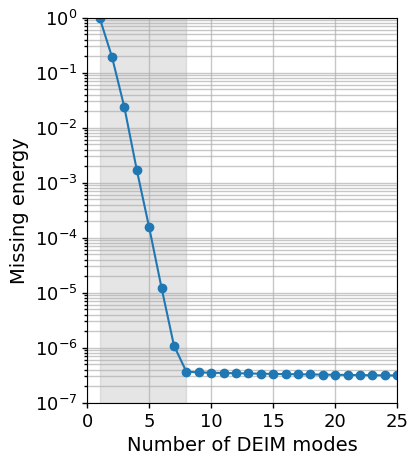

In [7]:
#guardiamo la missing energy del termine non-affine -> queste basi ridotte dopo le usiamo per davvero
cmap = plt.get_cmap('RdBu')
color = cmap(0.9)
 
missing = np.sqrt([np.sum(SS[ii:]) / np.sum(SS) for ii in range(len(SS))])
fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(range(1,26), missing[:25], '-o')
ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Number of DEIM modes',fontsize=14)
ax1.set_ylabel('Missing energy',fontsize=14)
#ax1.set_ylabel('Normalized eigenvalues',fontsize=14)
ax1.axvspan(1, NN, color='gray', alpha=0.2)
ax1.set_xlim([0,25])
ax1.set_ylim([1e-7, 1])
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
plt.savefig('plot/Missing energy.pdf', bbox_inches='tight')

In [8]:
# Define size of the training parameter set:
sTR = 10000
FISSION_ENERGY = 3.215E-11

# Define parameters ranges:
MIN_FR, MAX_FR = 0, 5.00E+19        
MIN_K, MAX_K =  0.9, 8    
MIN_FY, MAX_FY = 0.00, 0.3
MIN_LL, MAX_LL = 0.1E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
MIN_BC, MAX_BC = 0, 2.5E+03                                                                

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR))
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
LIST_GG = (LIST_FR * FISSION_ENERGY * LIST_LL**2)/LIST_K

# Extract z coordinates from the list of all Pq points coordinates and map those coordinates to the Pq points:
ZZ = np.sort(list(set(coordinates_Pq[:, 1])))
ZZ_1Dto2D = sparse.csr_matrix(np.array([coordinates_Pq[:, 1] == ZZ[kk] for kk in range(len(ZZ))]).T) * 1

# Compute a training set of concentration diffusion coefficients evaluated at the z coordinates: 
TEST = np.empty((len(ZZ), sTR))
for ii in range(sTR):
    TEST[:, ii] = ALPHA_C(ZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii], FISSION_RATE=LIST_FR[ii])

In [9]:
# Estimate the absolute and relative errors committed with this interpolation approach:
ABS_ERR = np.linalg.norm(TEST - BASIS_D_1D @ mapDAtoCO @ TEST[INT_COO, :], axis=0) 
REL_ERR = ABS_ERR / np.linalg.norm(TEST, axis=0)

# Print maximum error:
print(np.max(REL_ERR))

0.00030129690595584896


#### ASSEMBLE AFFINELY DECOMPOSED STIFFNESS MATRICES AND COMPUTE THEIR COERCIVITY CONSTANTS
impiega 1.3 secondi

In [15]:
# Define two mass matrices respectively linked to the regularity of the solution and of its time derivative:
Y_mass = stiff_C
X_mass = mass_C

# Initialise array for the partial stiffness matrices and for their coercivity constants:
list_basis_stiff_C = np.array([sparse.csr_matrix((mass_C.shape)) for ii in range(2*NN)])
list_coerc_stiff_C = np.zeros((2*NN))

# Iterate over the selected basis for the diffusion coefficient field
for ii in range(NN):

    # Assemble the radial and axial partial stiffness matrices associated with the basis of the diffusivity:
    list_basis_stiff_C[00+ii] = PxtoPqdx_C.T.dot(PxtoPqdx_C.multiply(BASIS_D_2D[:, ii:ii+1] * polar_weights_Pq[:, None]))
    list_basis_stiff_C[NN+ii] = PxtoPqdy_C.T.dot(PxtoPqdy_C.multiply(BASIS_D_2D[:, ii:ii+1] * polar_weights_Pq[:, None]))

    # Compute the sign of the axial and radial partial stiffness matrices:
    tsign_dz_C = np.sign(list_basis_stiff_C[NN + ii].trace())
    tsign_dr_C = np.sign(list_basis_stiff_C[00 + ii].trace())

    # Compute the coercivity constant of the axial and radial partial stiffness matrices:
    list_coerc_stiff_C[NN+ii] = tsign_dz_C / linalg.eigsh(Y_mass, k=1, M=tsign_dz_C * list_basis_stiff_C[NN+ii], which='LM', return_eigenvectors=False)[0]
    list_coerc_stiff_C[00+ii] = tsign_dr_C / linalg.eigsh(Y_mass, k=1, M=tsign_dr_C * list_basis_stiff_C[00+ii], which='LM', return_eigenvectors=False)[0]

#### COMPUTE THE INTERPOLATION COEFFICIENTS AND THE COERCIVITY COEFFICIENTS FOR ALL THE PARAMETERS

In [16]:
# Compute hte interpolation coefficients and the coercivity coefficients for the parameters in the training set:
list_inter_coef = np.empty((sTR, 2*NN))
list_coerc_coef = np.empty((sTR))

# Iterate over the training set:
for ii in range(sTR):
    cur_coef = mapDAtoCO @ ALPHA_C(INT_CZZ, T_BC=LIST_BC[ii], GAMMA_T=LIST_GG[ii], FISSION_RATE=LIST_FR[ii])

    # Compute the interpolation coefficients for the radial and axial partial stiffness matrices:
    list_inter_coef[ii, NN:] = cur_coef / LIST_LL[ii]**2
    list_inter_coef[ii, :NN] = cur_coef / LIST_RR[ii]**2

    # Compute a lower bound for the coercivity constants:
    list_coerc_coef[ii] = np.dot(list_coerc_stiff_C, list_inter_coef[ii, :])

# Compute interpolation and coercivity coeffientrs for the reference parameters:
cur_inter_coef = mapDAtoCO @ ALPHA_C(INT_CZZ, T_BC=T_BC, GAMMA_T=GAMMA_T, FISSION_RATE=FISSION_RATE)
cur_inter_coef = np.hstack((cur_inter_coef / RADIUS**2, cur_inter_coef / LENGTH**2))
cur_coerc_coef = np.dot(list_coerc_stiff_C, cur_inter_coef)

#### COMPUTE THE POD MODES OF THE REFERENCE SOLUTION

In [18]:
sol_new_C = np.loadtxt('reference case/Fullorder_Cfield.csv', delimiter=',')
# Compute the singular value decomposition of the gramian matrix:
AA, GG, BB = np.linalg.svd(sol_new_C[mask_in_C, :].T @ Y_mass @ sol_new_C[mask_in_C, :], full_matrices=False)

# Compute total Y-energy of the training set:
Y_energy = np.sum([Y_mass.dot(sol_new_C[mask_in_C, ii]).dot(sol_new_C[mask_in_C, ii]) for ii in range(N_ITER+1)])

# Determine number of POD modes to retain:
sRB_C = np.sum([np.sqrt(np.sum(GG[ii:]) / Y_energy) > 1e-4 for ii in range(len(GG))])

# Assemble POD modes for the concentration field at the reference parameters:
BASIS_C_2D = sol_new_C[mask_in_C, :] @ AA[:, :sRB_C] @ np.diag(np.reciprocal(np.sqrt(GG[:sRB_C])))

print(rf'Number of POD modes = {sRB_C}')

Number of POD modes = 8


#### ASSEMBLE REDUCED MATRICES (LATER MUST BE CODED AS THE METHOD OF A CLASS)

In [19]:
# Project the Y- and X-mass matrices on the reduced basis space:
Y_mass_RB = BASIS_C_2D.T @ Y_mass @ BASIS_C_2D
X_mass_RB = BASIS_C_2D.T @ X_mass @ BASIS_C_2D

# Compute Rietz representer and projection of the forcing term:
forc_C_rietz_RB = linalg.spsolve(Y_mass, forc_C)
forc_C_proje_RB = BASIS_C_2D.T @ forc_C

# Compute Rietz representer and projection of the mass matrix tested versus the POD basis functions: 
mass_C_right_RB = mass_C @ BASIS_C_2D
mass_C_rietz_RB = linalg.spsolve(Y_mass, mass_C_right_RB)
mass_C_proje_RB = BASIS_C_2D.T @ mass_C_right_RB

# Compute the Rietz representer and projection of all the partial stiffness matrices from the affine decomposition:
list_basis_stiff_C_right_RB = np.array([list_basis_stiff_C[ii] @ BASIS_C_2D for ii in range(2*NN)])
list_basis_stiff_C_rietz_RB = np.array([linalg.spsolve(Y_mass, list_basis_stiff_C_right_RB[ii]) for ii in range(2*NN)])
list_basis_stiff_C_proje_RB = np.array([BASIS_C_2D.T @ list_basis_stiff_C_right_RB[ii] for ii in range(2*NN)])

# Pre-assemble the scalar and vector terms for the residual energy computation:
DD_pr_bb = (forc_C_rietz_RB.T @ forc_C) * (SOURCE_C * SOURCE_C)
DD_pr_bm = (forc_C_rietz_RB.T @ mass_C_right_RB) * (- 2 * SOURCE_C / TIME_DELTA)
DD_pr_mm = (mass_C_rietz_RB.T @ mass_C_right_RB) * (  1 / (TIME_DELTA * TIME_DELTA))

# Pre-assemble all the tensor terms for the residual energy computation:
DD_pr_ab = np.array([ list_basis_stiff_C_right_RB[ii, :, :].T @ forc_C_rietz_RB for ii in range(2*NN)]) * (-2 * SOURCE_C)
DD_pr_am = np.array([ list_basis_stiff_C_right_RB[ii, :, :].T @ mass_C_rietz_RB for ii in range(2*NN)]) * ( 2 / TIME_DELTA)
DD_pr_aa = np.array([[list_basis_stiff_C_right_RB[ii, :, :].T @ list_basis_stiff_C_rietz_RB[jj, :, :] for ii in range(2*NN)] for jj in range(2*NN)])

# Compute the weights for the integration of the reduced basis solutions:
weights_RB = np.ones((sFO_Px)) @ mass_Px[:, mask_in_C] @ BASIS_C_2D

#### COMPUTE REDUCED BASIS SOLUTION

In [20]:
# Assemble current reduced basis stiffness matrix:
stiff_C_proje_RB = np.tensordot(cur_inter_coef, list_basis_stiff_C_proje_RB, axes=[0, 0])
stiff_C_exact_RB = BASIS_C_2D.T @ stiff_C @ BASIS_C_2D

# Assemble current stiffness cross term for the computation of the residual energy:
cur_DD_pr_ab = np.tensordot(cur_inter_coef, DD_pr_ab, axes=[0, 0])
cur_DD_pr_am = np.tensordot(cur_inter_coef, DD_pr_am, axes=[0, 0])
cur_DD_pr_aa = np.tensordot(cur_inter_coef, np.tensordot(cur_inter_coef, DD_pr_aa, axes=[0, 0]), axes=[0, 0])

# Initialise reduced basis concentration solution:
sol_new_C_RB = np.zeros((sRB_C, N_ITER+1))
sol_new_C_FO = np.zeros((len(mask_in_C), N_ITER+1))

# Initialise errors and errors estimators:
energy_residual = np.empty((N_ITER))
energy_solution = np.empty((N_ITER))
energy_toterror = np.empty((N_ITER))

#
inte_C_RB = inte_C @ BASIS_C_2D

# Integrate using forward Euler up to the final time:
verbose = True
for ii in range(N_ITER):
    cur_time = ii * TIME_DELTA

    # Print current iteration and average temperature and concentration:
    if verbose:
        print('Current time:', cur_time, 's')
        print('Average concentration:', inte_C_RB @ sol_new_C_RB[:, ii], 'atm/m^3\n')

    # Assemble current left-hand-side and right-hand-side
    cur_lhs_RB = mass_C_proje_RB + TIME_DELTA * stiff_C_proje_RB
    cur_rhs_RB = mass_C_proje_RB.dot(sol_new_C_RB[:, ii:ii+1]) + TIME_DELTA * SOURCE_C * forc_C_proje_RB

    # Compute concentration in the interior of the domain:
    sol_new_C_RB[:, ii+1] = np.linalg.solve(cur_lhs_RB, cur_rhs_RB)[:, 0]
    sol_new_C_FO[:, ii+1] = BASIS_C_2D @ sol_new_C_RB[:, ii+1]
    
    # Compute partial errors and error bounds:
    energy_toterror[ii] = TIME_DELTA * stiff_C.dot(sol_new_C_FO[:, ii+1] - sol_new_C[mask_in_C, ii+1]).dot(sol_new_C_FO[:, ii+1] - sol_new_C[mask_in_C, ii+1])
    energy_solution[ii] = TIME_DELTA * stiff_C_proje_RB.dot(sol_new_C_RB[:, ii+1]).dot(sol_new_C_RB[:, ii+1])
    energy_residual[ii] = TIME_DELTA * (DD_pr_bb[0] + DD_pr_bm.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]) +\
                                        DD_pr_mm.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]).dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]) +\
                                        cur_DD_pr_ab.dot(sol_new_C_RB[:, ii+1]) + cur_DD_pr_aa.dot(sol_new_C_RB[:, ii+1]).dot(sol_new_C_RB[:, ii+1]) +\
                                        cur_DD_pr_am.dot(sol_new_C_RB[:, ii+1] - sol_new_C_RB[:, ii]).dot(sol_new_C_RB[:, ii+1]))

# Print current iteration and average temperature and concentration:
if verbose: 
    print('Final time:', N_ITER * TIME_DELTA, 's')
    print('Average concentration:', inte_C_RB @ sol_new_C_RB[:, -1], 'atm/m^3\n\n')

# Add final term energies:
energy_solution[-1] += mass_C_proje_RB.dot(sol_new_C_RB[:, -1]).dot(sol_new_C_RB[:, -1])
energy_toterror[-1] += mass_C.dot(sol_new_C[mask_in_C, -1] - sol_new_C_FO[:, -1]).dot(sol_new_C[mask_in_C, -1] - sol_new_C_FO[:, -1])

# Print errors and error bounds:
print('Error bound:', np.sqrt(np.sum(energy_residual) / np.sum(energy_solution) / cur_coerc_coef) )
print('Error exact:', np.sqrt(np.sum(energy_toterror) / np.sum(energy_solution)) )

Current time: 0.0 s
Average concentration: 0.0 atm/m^3

Current time: 10000.0 s
Average concentration: 6.077970823773112e+22 atm/m^3

Current time: 20000.0 s
Average concentration: 1.1627102283016573e+23 atm/m^3

Current time: 30000.0 s
Average concentration: 1.6790510821246518e+23 atm/m^3

Current time: 40000.0 s
Average concentration: 2.1643135899350284e+23 atm/m^3

Current time: 50000.0 s
Average concentration: 2.6230994915020693e+23 atm/m^3

Current time: 60000.0 s
Average concentration: 3.0586080633622834e+23 atm/m^3

Current time: 70000.0 s
Average concentration: 3.4732521216600335e+23 atm/m^3

Current time: 80000.0 s
Average concentration: 3.86894550306158e+23 atm/m^3

Current time: 90000.0 s
Average concentration: 4.247256892225978e+23 atm/m^3

Current time: 100000.0 s
Average concentration: 4.60950275784971e+23 atm/m^3

Current time: 110000.0 s
Average concentration: 4.95680864681533e+23 atm/m^3

Current time: 120000.0 s
Average concentration: 5.2901519299856895e+23 atm/m^3

C

#### SAVE ESSENTIAL FILES

In [21]:
# Save essentail files:
np.save('model_files/FF_FO.npy', forc_C)
np.save('model_files/XX_FO.npy', np.array([mass_C]))
np.save('model_files/YY_FO.npy', np.array([stiff_C]))
np.save('model_files/KK_FO.npy', list_basis_stiff_C)
np.save('model_files/CC_FO.npy', list_coerc_stiff_C)
np.save('model_files/ZZ_FO.npy', INT_CZZ)
np.save('model_files/II_FO.npy', mapDAtoCO)
np.save('model_files/AA_FO.npy', inte_C)

In [1]:
# Pulizia
from IPython import get_ipython
get_ipython().run_line_magic('clear', '')
get_ipython().run_line_magic('reset', '-f')

# Import libraries:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import time
import sys
import json
import h5py
import time

# Import user defined libraries:
from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

In [2]:
#Define size of the training parameter set:
sTR = 10000
FISSION_ENERGY = 3.215e-11

# Define parameters ranges:
MIN_FR, MAX_FR = 0, 5.00E+19        
MIN_K, MAX_K =  0.9, 8    
MIN_FY, MAX_FY = 0.00, 0.3
MIN_LL, MAX_LL = 0.1E-3, 1.25E-3
MIN_RR, MAX_RR = 0.75E-5, 1.25E-5
MIN_BC, MAX_BC = 0, 2.5E+03         

# Compute a list of random parameters within the range:
LIST_FR = np.random.uniform(low=MIN_FR, high=MAX_FR, size=(sTR)) 
LIST_BC = np.random.uniform(low=MIN_BC, high=MAX_BC, size=(sTR))
LIST_LL = np.random.uniform(low=MIN_LL, high=MAX_LL, size=(sTR))
LIST_RR = np.random.uniform(low=MIN_RR, high=MAX_RR, size=(sTR))
LIST_FY = np.random.uniform(low=MIN_FY, high=MAX_FY, size=(sTR))
LIST_K = np.random.uniform(low=MIN_K, high=MAX_K, size=(sTR))
LIST_GG = (LIST_FR * FISSION_ENERGY * LIST_LL**2)/LIST_K

#### POD-GREEDY

In [24]:
import numpy as np 
loaded_data = np.load('checkpoint/training_set.npz')
LIST_FR = loaded_data['FR']
LIST_BC = loaded_data['BC']
LIST_LL = loaded_data['LL']
LIST_RR = loaded_data['RR']
LIST_FY = loaded_data['FY']
LIST_K = loaded_data['K']
LIST_GG = loaded_data['GG']

sTR = LIST_BC.shape[0]

In [3]:
#############################
##### SAVE CHECKPOINT #######
#############################
def salva_checkpoint(step, cur_BC, cur_FR, cur_LL, cur_RR, cur_FY, cur_K, MM_RB, FF_RB, KK_RB, AA_RB, ZZ_CO, II_CO, basis, cur_err_bounds, elapsed_time):
    import os
    worst_error = cur_err_bounds[np.argmax(cur_err_bounds)]  # Salva il valore dell'errore massimo
    
    # Creazione della cartella per lo step corrente
    step_folder = f"checkpoint/step_{step}"
    os.makedirs(step_folder, exist_ok=True)

    # Salvataggio dei parametri in formato JSON
    data = {
        "N_AVOG": 6.022141E+23,
        "N_BOLT": 1.380649E-23,
        "FISSION_ENERGY": 3.215E-11,
        "FISSION_RATE": cur_FR,
        "FUEL_THERMAL_CONDUCTIVITY": cur_K,
        "FISSION_YIELD": cur_FY,
        "LENGTH": cur_LL,
        "RADIUS": cur_RR,
        "T_BC": cur_BC,
        "Maximum cur_err_bounds": cur_err_bounds[np.argmax(cur_err_bounds)],
        "TIME_ELAPSED": elapsed_time
    }

    json_path = os.path.join(step_folder, "worst_reconstructed_parameters.json")
    with open(json_path, "w") as json_file:
        json.dump(data, json_file, indent=4)
    # with open("checkpoint/worst reconstructed parameters.json", "w") as json_file:
    #     json.dump(data, json_file, indent=4)

    # Salvataggio delle matrici in un file HDF5
    hdf5_path = os.path.join(step_folder, "matrici_RB.h5")
    with h5py.File(hdf5_path, 'w') as hf:
    #with h5py.File('checkpoint/matrici_RB.h5', 'w') as hf:
        hf.create_dataset('MM_RB', data=MM_RB)
        hf.create_dataset('FF_RB', data=FF_RB)
        hf.create_dataset('KK_RB', data=KK_RB)
        hf.create_dataset('AA_RB', data=AA_RB)
        hf.create_dataset('ZZ_CO', data=ZZ_CO)
        hf.create_dataset('II_CO', data=II_CO)
        hf.create_dataset('basis', data=basis)

    return worst_error

#############################
##### LOAD CHECKPOINT #######
#############################
import os
def carica_checkpoint():
    try:
        # Caricamento dei parametri dal file JSON
        with open("checkpoint/worst_reconstructed_parameters.json", "r") as json_file:
            data = json.load(json_file)
        cur_BC = data["T_BC"]
        cur_FR = data["FISSION_RATE"]
        cur_LL = data["LENGTH"]
        cur_RR = data["RADIUS"]
        cur_FY = data["FISSION_YIELD"]
        cur_K = data["FUEL_THERMAL_CONDUCTIVITY"]
        elapsed_time = data["TIME_ELAPSED"]

        # Caricamento delle basi dal file HDF5
        with h5py.File('checkpoint/matrici_RB.h5', 'r') as hf:
            basis = hf['basis'][:]
    
    except FileNotFoundError:
        # Se i file non sono trovati, imposta i parametri di default e matrici vuote
        print("Checkpoint files not found. Starting from scratch.")
        
        # Parametri di default
        cur_FR = 3.00E+19
        cur_K = 2.208
        cur_FY = 2.40E-01
        cur_LL = 1.00E-03
        cur_RR = 1.00E-05
        cur_BC = 2.00E+03
        
        basis = np.empty((FiniteElementCylinderSolver.sFO, 0))
        elapsed_time = 0  # Inizio da zero
    
    return cur_BC, cur_FR, cur_LL, cur_RR, cur_FY, cur_K, basis, elapsed_time


In [4]:
start_time = time.time()
# cur_FR = 3.00E+19
# cur_K = 2.208
# cur_FY = 2.40E-01
# cur_LL = 1.00E-03
# cur_RR = 1.00E-05
# cur_BC = 2.00E+03
cur_dt = 1.00E+04
step = 1

#Define empty basis functions matrix and empty list of error bounds:
#cur_basis = np.empty((FiniteElementCylinderSolver.sFO, 0))
cur_err_bounds = np.empty((sTR))

cur_BC, cur_FR, cur_LL, cur_RR, cur_FY, cur_K, cur_basis, check_point_elapsed_time = carica_checkpoint()

cost_FO = 0 
cost_POD = 0
cost_EB = 0
# Enter reduced basis space loop:
new_sRB = np.inf
while new_sRB > 0:
    
    # Assemble full order model and compute full order solution associated with the current parameter selection:
    t0 = time.time()
    solver_FO = FiniteElementCylinderSolver()
    solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
    solution_FO = solver_FO.solve(n_steps=1000, verbose=False)
    cost_FO += time.time()-t0

    # Compute orthogonal complement to the basis function and solution energy:
    t0 = time.time()
    orthogonal_FO = solution_FO - cur_basis @ np.linalg.solve(cur_basis.T @ solver_FO.XX_FO @ cur_basis, cur_basis.T @ solver_FO.XX_FO @ solution_FO)
    solution_energy_FO = np.einsum('ik,ik', solver_FO.XX_FO @ solution_FO, solution_FO)
    
    # Extract the POD basis from the full order solution:
    AA, GG, BB = np.linalg.svd(orthogonal_FO.T @ solver_FO.XX_FO @ orthogonal_FO, full_matrices=False)
    new_sRB = np.sum([np.sqrt(np.sum(GG[ii:]) / solution_energy_FO) > 1e-5 for ii in range(len(GG))])
    cur_basis = np.hstack((cur_basis, orthogonal_FO @ AA[:, :new_sRB] @ np.diag(np.reciprocal(np.sqrt(GG[:new_sRB])))))
    cost_POD += time.time()-t0

    # Assemble reduced basis model:
    t0 = time.time()
    solver_RB = ReducedBasisCylinderSolver(cur_basis)
    for kk in range(sTR):
        solver_RB.assemble(F_YIELD=LIST_FY[kk], F_RATE=LIST_FR[kk], T_BC=LIST_BC[kk], LENGTH=LIST_LL[kk], RADIUS=LIST_RR[kk], KTH=LIST_K[kk], dt=cur_dt)

        # Compute current reduced basis solution and error bound:
        solution_RB, cur_err_bounds[kk] = solver_RB.solve(n_steps=1000, error_bound=True)
    cost_EB += time.time()-t0

    # Identify new parameters where to evaluate the full order model:
    #cur_FY = cur_FY
    cur_FY = LIST_FY[np.argmax(cur_err_bounds)]
    cur_FR = LIST_FR[np.argmax(cur_err_bounds)]
    cur_BC = LIST_BC[np.argmax(cur_err_bounds)]
    cur_LL = LIST_LL[np.argmax(cur_err_bounds)]
    cur_RR = LIST_RR[np.argmax(cur_err_bounds)]
    cur_K = LIST_K[np.argmax(cur_err_bounds)]

    # Show worse reconstructed parameter configuration:
    print("The current reduced basis size is", cur_basis.shape[1])
    print("The selected Fission Rate is", cur_FR, "f/s")
    print("The selected Fuel Thermal Conductivity is", cur_K, "W/(m K)")
    print("The selected Fission Yield is", cur_FY, "at/fiss")
    print("The selected Grain Length is", cur_LL, "m")
    print("The selected Grain Radius is", cur_RR, "m")
    print("The selected Boundary Temperature is", cur_BC, "K")

    current_time = time.time()
    elapsed_time = current_time - start_time 
    total_elapsed_time = elapsed_time + check_point_elapsed_time 

    # Salvataggio dello stato dopo ogni ciclo
    MM_RB = solver_RB.XX_RB    #matrice di massa. 2D
    FF_RB = solver_RB.FF_RB    #funzionalità contro il vettore unitario. 1D
    KK_RB = solver_RB.KK_RB    #basi della decomposizione affine della stiffness. 3D
    AA_RB = solver_RB.AA_RB    #l'integratore per calcolare il valor medio sul volume data la soluzione ridotta, questo può essere sostituito dalla funzione che calcola il valor medio su diversi slice. 1D
    ZZ_CO = solver_RB.ZZ_FO    #coordinate a cui dobbiamo valutare la temperatura. 1D
    II_CO = solver_RB.II_FO    #coefficienti che mappano i valori del coefficiente di diffusione valutata sulle temperature nei coefficienti di combinazione lineare della decomposizione affine. 2D
    basis = cur_basis 

    #worst_error = cur_err_bounds[np.argmax(cur_err_bounds)]
    worst_error = salva_checkpoint(step, cur_BC, cur_FR, cur_LL, cur_RR, cur_FY, cur_K, MM_RB, FF_RB, KK_RB, AA_RB, ZZ_CO, II_CO, cur_basis, cur_err_bounds, total_elapsed_time)
    print(f"Maximum cur_err_bounds: {worst_error}")
    print(f"Elapsed time during this simulation: {elapsed_time / 60:.2f} minutes")
    print(f"Overall elapsed time (considering also the checkpoint): {total_elapsed_time/ 60:.2f} minutes\n")

    # Incrementa il contatore dello step
    step += 1
print(rf'Il tempo impiegato dal FO = {cost_FO}, Il tempo impiegato dalla POD = {cost_POD}, Il tempo impiegato da error bound = {cost_EB}')

Checkpoint files not found. Starting from scratch.
The current reduced basis size is 9
The selected Fission Rate is 4726850869113397.0 f/s
The selected Fuel Thermal Conductivity is 6.625788543061234 W/(m K)
The selected Fission Yield is 0.05032798663961517 at/fiss
The selected Grain Length is 0.000656762823927696 m
The selected Grain Radius is 9.31457904169641e-06 m
The selected Boundary Temperature is 666.3511353641962 K
Maximum cur_err_bounds: 82.18136989681005
Elapsed time during this simulation: 0.94 minutes
Overall elapsed time (considering also the checkpoint): 0.94 minutes

The current reduced basis size is 11
The selected Fission Rate is 4.739694544485227e+19 f/s
The selected Fuel Thermal Conductivity is 6.836458166039823 W/(m K)
The selected Fission Yield is 0.26166509972356244 at/fiss
The selected Grain Length is 0.0001023055538740374 m
The selected Grain Radius is 1.2219708240144428e-05 m
The selected Boundary Temperature is 2262.443127090189 K
Maximum cur_err_bounds: 28.577

KeyboardInterrupt: 

In [27]:
cur_err_bounds[np.argmax(cur_err_bounds)]

np.float64(0.02511927102840516)

In [ ]:
#np.savez('checkpoint/training_set.npz', FR=LIST_FR, BC=LIST_BC, LL=LIST_LL, RR=LIST_RR, FY=LIST_FY, K=LIST_K, GG=LIST_GG)

In [33]:
import json
# Parametri con nomi diretti
data = {
    "N_AVOG": 6.022141E+23,
    "N_BOLT": 1.380649E-23,
    "FISSION_ENERGY": 3.215E-11,
    "FISSION_RATE": cur_FR,
    "FUEL_THERMAL_CONDUCTIVITY": cur_K,
    "FISSION_YIELD": cur_FY,
    "LENGTH": cur_LL,
    "RADIUS": cur_RR,
    "T_BC": cur_BC,
    "Maximum cur_err_bounds": cur_err_bounds[np.argmax(cur_err_bounds)], 
    "TIME_ELAPSED": total_elapsed_time
}

# Scrittura su file JSON
with open("checkpoint/worst reconstructed parameters.json", "w") as json_file:
    json.dump(data, json_file, indent=4)


In [34]:
MM_RB = solver_RB.XX_RB    #matrice di massa. 2D
FF_RB = solver_RB.FF_RB    #funzionalità contro il vettore unitario. 1D
KK_RB = solver_RB.KK_RB    #basi della decomposizione affine della stiffness. 3D
AA_RB = solver_RB.AA_RB    #l'integratore per calcolare il valor medio sul volume data la soluzione ridotta, questo può essere sostituito dalla funzione che calcola il valor medio su diversi slice. 1D
ZZ_CO = solver_RB.ZZ_FO    #coordinate a cui dobbiamo valutare la temperatura. 1D
II_CO = solver_RB.II_FO    #coefficienti che mappano i valori del coefficiente di diffusione valutata sulle temperature nei coefficienti di combinazione lineare della decomposizione affine. 2D
basis = cur_basis 

In [35]:
# Salviamo tutte le matrici in un unico file HDF5
import h5py
with h5py.File('checkpoint/matrici_RB.h5', 'w') as hf:
    hf.create_dataset('MM_RB', data=MM_RB)
    hf.create_dataset('FF_RB', data=FF_RB)
    hf.create_dataset('KK_RB', data=KK_RB)
    hf.create_dataset('AA_RB', data=AA_RB)
    hf.create_dataset('ZZ_CO', data=ZZ_CO)
    hf.create_dataset('II_CO', data=II_CO)
    hf.create_dataset('basis', data=basis)